# Figure 3

- See UMAP.ipynb for UMAP plots


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [2]:
master = pd.read_csv('master_table_min50_control_mean_invitro.csv')

master_targ = master[master['classification']=='targeting guide']

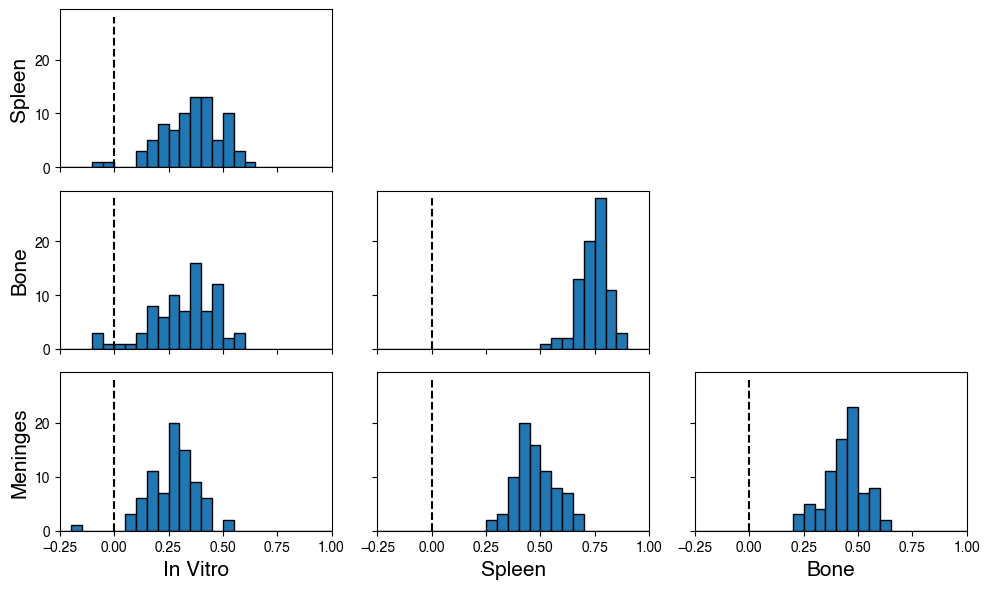

In [3]:
u, c = np.unique(master_targ['gene_name_m'], return_counts=True)
dd = pd.DataFrame(dict(zip(['gene', 'gRNA count'], [u,c]))).sort_values(by='gRNA count', ascending=False)

dd = dd[dd['gRNA count']>=50]


samples = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']

spleen_bone = []
spleen_meninges = []
spleen_d15 = []
bone_meninges = []
bone_d15 = []
d15_meninges = []


for gene in dd['gene']:
    ptprt = master_targ[(master_targ['gene_name_m']==gene)]

    for i, val in enumerate(samples):

        x = ptprt[val]

        for i2, val2 in enumerate(samples):

            y = ptprt[val2]

            s1 = scipy.stats.pearsonr(x,y).statistic

            if val=='LFC_Spleen':
                if val2 =='LFC_Bone':
                    spleen_bone.append(s1)

                elif val2=='LFC_Meninges':
                    spleen_meninges.append(s1)

                elif val2=='LFC_In Vitro D15':
                    spleen_d15.append(s1)

            elif val == 'LFC_Bone':
                if val2=='LFC_Meninges':
                    bone_meninges.append(s1)
                elif val2=='LFC_In Vitro D15':
                    bone_d15.append(s1)
            elif val=='LFC_In Vitro D15':
                if val2=='LFC_Meninges':
                    d15_meninges.append(s1)
            
            else:
                continue

fig, ax = plt.subplots(3,3,figsize=(10,6), sharex=True, sharey=True)

bins = np.linspace(-1,1,41)

ax[0][0].hist(spleen_d15, bins = bins, linewidth=1, edgecolor='black')
ax[1][0].hist(bone_d15, bins = bins, linewidth=1, edgecolor='black')
ax[2][0].hist(d15_meninges, bins = bins, linewidth=1, edgecolor='black')
ax[1][1].hist(spleen_bone, bins = bins, linewidth=1, edgecolor='black')
ax[2][1].hist(spleen_meninges, bins = bins, linewidth=1, edgecolor='black')
ax[2][2].hist(bone_meninges, bins = bins, linewidth=1, edgecolor='black')
ax[0][0].plot([0,0],[0,28], linestyle='dashed', color='black')
ax[1][0].plot([0,0],[0,28], linestyle='dashed', color='black')
ax[2][0].plot([0,0],[0,28], linestyle='dashed', color='black')
ax[1][1].plot([0,0],[0,28], linestyle='dashed', color='black')
ax[2][1].plot([0,0],[0,28], linestyle='dashed', color='black')
ax[2][2].plot([0,0],[0,28], linestyle='dashed', color='black')

ax[0][0].set_ylabel('Spleen', fontsize=15)
ax[1][0].set_ylabel('Bone', fontsize=15)
ax[2][0].set_ylabel('Meninges', fontsize=15)

ax[2][0].set_xlabel('In Vitro', fontsize=15)
ax[2][1].set_xlabel('Spleen', fontsize=15)
ax[2][2].set_xlabel('Bone', fontsize=15)

ax[0][0].set_xlim(-.25,1)

fig.delaxes(ax[0][1])
fig.delaxes(ax[0][2])
fig.delaxes(ax[1][2])
fig.tight_layout()

In [4]:
a = ['In Vitro vs. Spleen', 'In Vitro vs. Bone', 'In Vitro vs. Meninges', 'Spleen vs. Bone', 'Spleen vs. Meninges', 'Bone vs. Meninges']
b = [spleen_d15, bone_d15, d15_meninges, spleen_bone, spleen_meninges, bone_meninges]

df_holder = []
for i, val in enumerate(b):
    hh = a[i]
    d1 = pd.DataFrame(dict(zip(['Correlation'], [val])))
    d1['Comparison'] = hh
    df_holder.append(d1)

comps = pd.concat(df_holder).reset_index(drop=True)

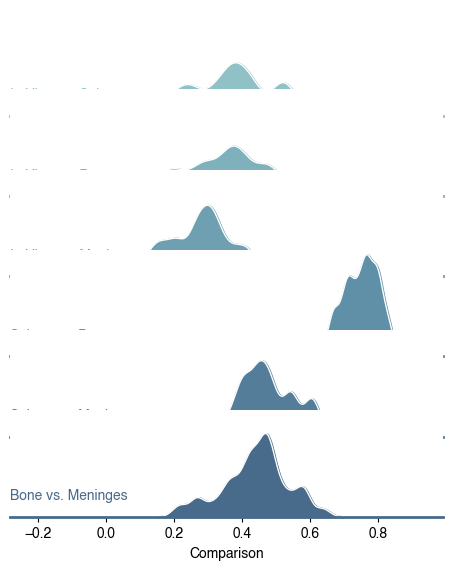

In [5]:
# Create the data
#rs = np.random.RandomState(1979)
#x = rs.randn(500)
#g = np.tile(list("ABCDEFGHIJ"), 50)
#df = pd.DataFrame(dict(x=x, g=g))
#m = df.g.map(ord)
#df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(comps, row="Comparison", hue="Comparison", aspect=5, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Correlation",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

g.map(sns.kdeplot, "Correlation", clip_on=False, color="w", lw=1, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Comparison")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

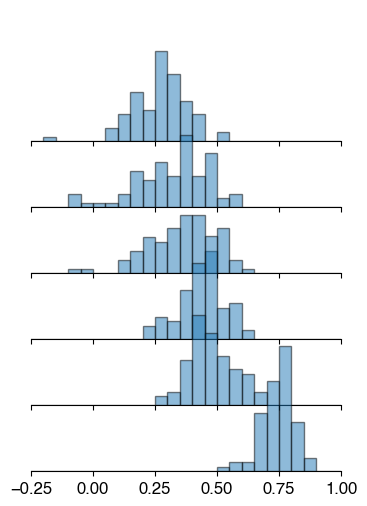

In [6]:
fig, ax= plt.subplots(6,1, figsize=(4,6), sharey=True, sharex=True)

a = ['In Vitro vs. Meninges', 'In Vitro vs. Bone', 'In Vitro vs. Spleen', 'Bone vs. Meninges','Spleen vs. Meninges', 'Spleen vs. Bone',]

bins = np.linspace(-1,1,41)
for idx, val in enumerate(a):

    subset = comps[comps['Comparison']==val]
    ax[idx].hist(subset['Correlation'], bins=bins, linewidth=1, edgecolor='black', alpha=.5)
    ax[idx].spines[['top', 'right', 'left']].set_visible(False)
    ax[idx].tick_params(axis='x', which='major', labelsize=12)
    ax[idx].set_yticks([])
    ax[idx].patch.set_facecolor('None')

ax[0].set_xlim(-.25,1)

fig.subplots_adjust(hspace=-.5)

#fig.savefig('figures/corr_hist.pdf')
#ax.set
#fig.tight_layout()

In [41]:
comps

,Correlation,Comparison
0,0.377321,In Vitro vs. Spleen
1,0.365241,In Vitro vs. Spleen
2,0.321450,In Vitro vs. Spleen
3,0.557096,In Vitro vs. Spleen
4,0.507627,In Vitro vs. Spleen
...,...,...
475,0.264438,Bone vs. Meninges
476,0.308475,Bone vs. Meninges
477,0.517114,Bone vs. Meninges
478,0.468589,Bone vs. Meninges


# tissue specific hits

In [45]:
master = pd.read_csv('master_table_min50_control_mean_invitro.csv')

master_targ = master[master['classification']=='targeting guide']

hh = []
for i in master_targ['HGVSp_h']:
    if type(i)==str:
        i2 = i.replace('delins', '')
        hh.append(i2)
    else:
        hh.append('Non-coding')

master_targ['HGVSp_h']=hh
#master_targ['HGVSp_h'] = [i.replace('delins', '') for i in master_targ['HGVSp_h'] if type(i)==str]

#and add TSG/Oncogene info

cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')


t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in master_targ.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

master_targ['Role in Cancer']=gene_type

In [46]:
master_targ


samples = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']


for idx, val in enumerate(samples):

    nums = [0,1,2,3]
    nums.remove(idx)

    considering = master_targ[val]
    avgs = np.average(master_targ[[samples[i] for i in nums]], axis=1)

    delta = considering-avgs
    master_targ[f"d_{val.split('_')[1]}"] = delta




In [9]:
gRNAs_UMAP = []

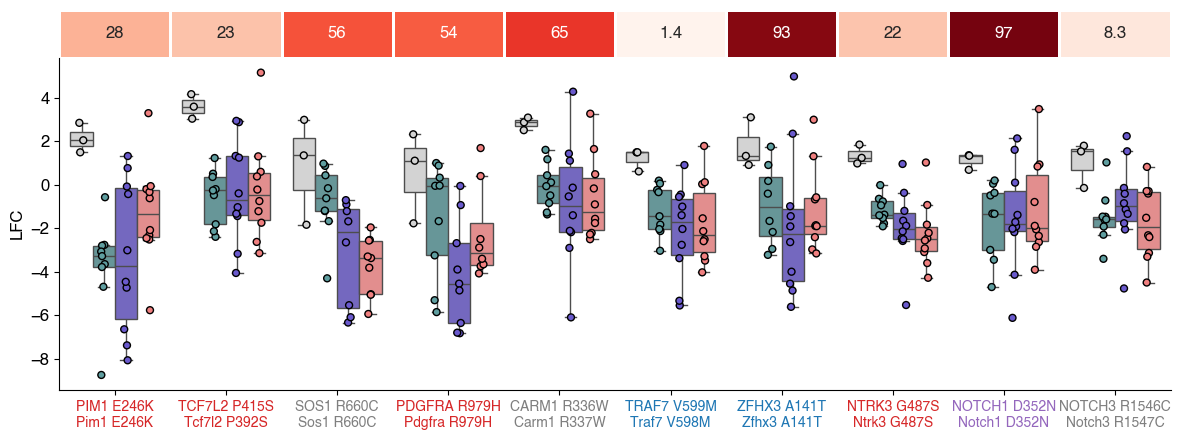

In [10]:
# in vitro specific
t = master_targ.sort_values(by='d_In Vitro D15', ascending=False)
t1 = t[(t['LFC_Spleen']<0) & (t['LFC_Meninges']<0) & (t['LFC_Bone']<0) & (t['LFC_In Vitro D15']>1) & (t['target_base_edit_perc']>=1)][:10]

gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(12,4.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=False, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/invitro_specific.pdf')

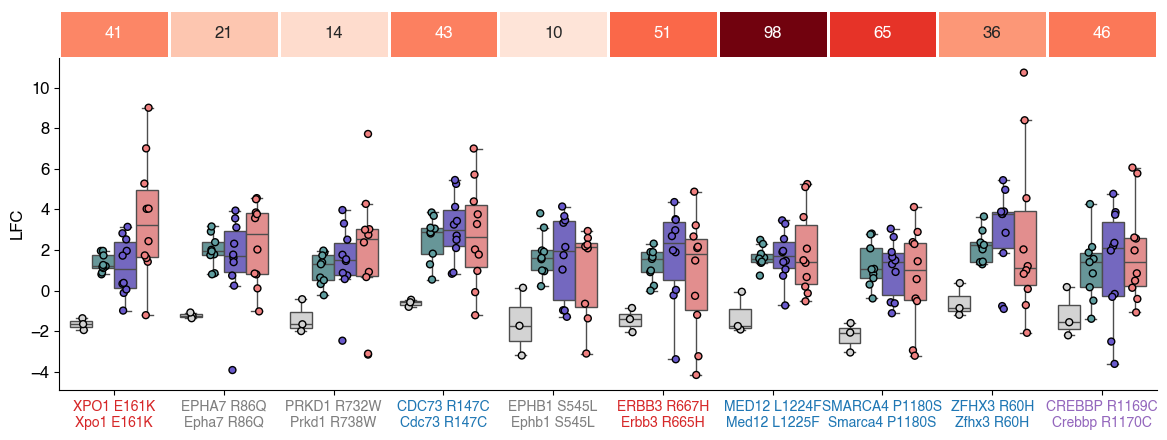

In [11]:
#in vivo specific
t = master_targ.sort_values(by='d_In Vitro D15', ascending=True)
t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(12,4.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=False, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

fig.tight_layout()
fig.subplots_adjust(hspace=0)

#fig.savefig('figures/invivo_specific.pdf')

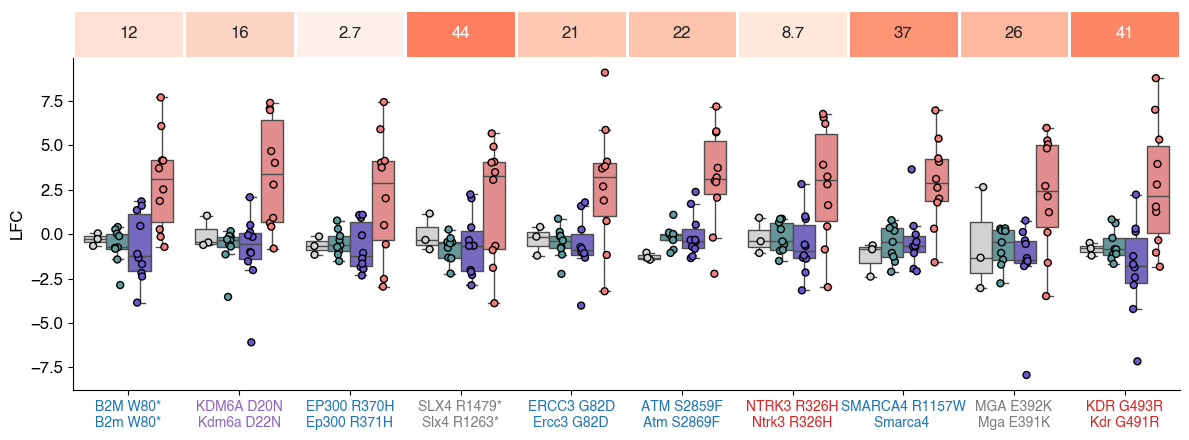

In [20]:
#meninges specific
t = master_targ.sort_values(by='d_Meninges', ascending=False)
t1 = t[(t['LFC_Spleen']<0) & (t['LFC_Meninges']>2) & (t['LFC_Bone']<0) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]

#t1 = t[(t['LFC_Spleen']<0.05) & (t['LFC_Meninges']>2) & (t['LFC_Bone']<0.05) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=10)][:10]

gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    if 'p.' in b:
        b = b[2:]
    if d == 'Not calculated (legacy)':
        d = ''

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(12,4.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']
palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=False, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/meninges_specific.pdf')

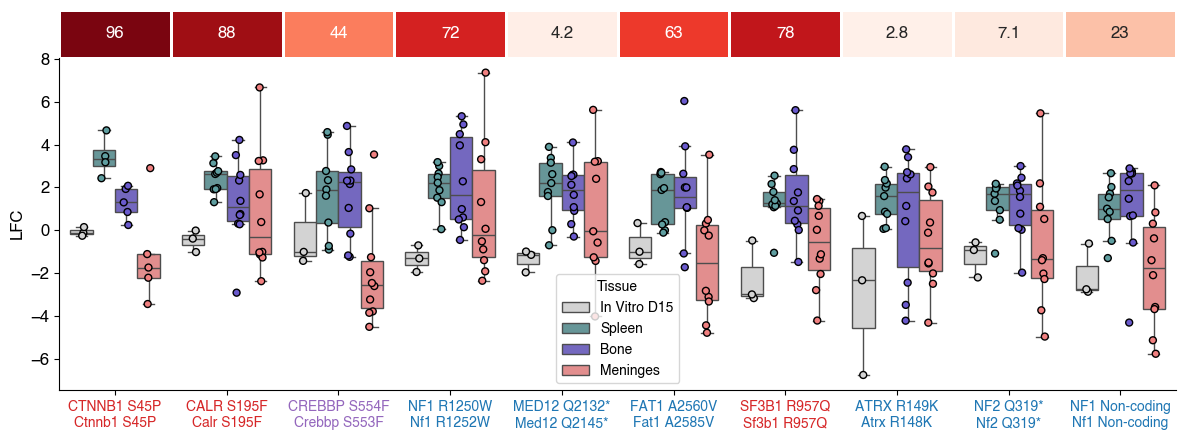

In [49]:
#bone/spleen specific
t = master_targ.sort_values(by='d_Spleen', ascending=False)
t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<0) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Bone']>1) & (t['LFC_In Vitro D15']<0) & (t['target_base_edit_perc']>=1)][:10]
#t1 = t[(t['LFC_Spleen']<-2)  & (t['LFC_In Vitro D15']<0.5) & (t['LFC_In Vitro D15']>-0.5) & (t['target_base_edit_perc']>=1) & (t['FDR_Spleen']<.05)][:20]


#t1 = t[:10]

#t1 = t[(t['LFC_Spleen']>1) & (t['LFC_Meninges']<-0.5) & (t['LFC_In Vitro D15']<0.05) & (t['target_base_edit_perc']>=1)][:10]


gRNAs_UMAP.append(list(t1['gRNA_id']))

samples2 = ['In Vitro D15', 'Spleen', 'Bone', 'Meninges']

#samples2 = ['In Vitro D15', 'Spleen',] #, 'Meninges']

name = []
tissue = []
LFC = []

for i, val in t1.iterrows():
    a = val['gene_name_h']
    b = val['HGVSp_h']
    c = val['gene_name_m']
    d = val['HGVSp_m']

    n = f'{a} {b}\n{c} {d}'

    for s in samples2:
        treat = val[f'treat_count_{s}']
        control = val[f'control_mean_{s}']
        
        lfcs_reps = np.log2(np.asarray([float(ii) for ii in treat.split('/')])/float(control))
        
        for jj in lfcs_reps:
            LFC.append(jj)
            name.append(n)
            tissue.append(s)

plotting_df = pd.DataFrame(dict(zip(['Mutation', 'Tissue', 'LFC'], [name, tissue, LFC])))
    
fig, ax = plt.subplots(2,1, figsize=(12,4.5), height_ratios=[1,7], sharex=False)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100)
g = sns.boxplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], legend=True, palette=palette, showfliers=False)
sns.stripplot(data=plotting_df, x='Mutation', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlabel('')
ax[1].set_ylabel('LFC', fontsize=12)

#ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='x', which='major', labelsize=10)
ax[1].tick_params(axis='y', which='major', labelsize=12)

color_dict = {'Oncogene':'tab:red', 'Oncogene/TSG':'tab:purple', 'TSG':'tab:blue', 'Undefined':'tab:grey'}
t2 = list(t1['Role in Cancer'])
for idx, tick_label in enumerate(g.axes.get_xticklabels()):

    tick_label.set_color(color_dict[t2[idx]])

fig.tight_layout()
fig.subplots_adjust(hspace=0)
#fig.savefig('figures/bone_spleen_specific.pdf')

In [50]:
t1 = t[(t['LFC_Spleen']<.5) & (t['LFC_Meninges']>3) & (t['LFC_Bone']<.5) & (t['LFC_In Vitro D15']<0.5) & (t['target_base_edit_perc']>=1)][:10]
t1

,gRNA_id,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,...,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc,Role in Cancer,d_In Vitro D15,d_Spleen,d_Bone,d_Meninges
10424,gRNA_10473,8687,RB1,ENSG00000139687.9,ENST00000267163.4,chr13,27.0,+,True,49039374.0,...,261,0.000000,70.498084,0.000000,100.000000,TSG,-1.463840,-0.169627,-1.836547,3.470013
9629,gRNA_9672,7966,PTCH1,ENSG00000185920.11,ENST00000331920.6,chr9,23.0,-,True,98231217.0,...,4009,32.576702,98.802694,0.448990,66.201048,TSG,-1.541117,-0.403917,-1.277490,3.222523
1492,gRNA_1501,1229,BCOR,ENSG00000183337.12,ENST00000378444.4,chrX,14.0,-,True,39934252.0,...,540,31.851852,69.259259,0.370370,58.888889,TSG,-2.192063,-0.432010,-0.775343,3.399417
1060,gRNA_1067,885,ATM,ENSG00000149311.13,ENST00000278616.4,chr11,62.0,+,True,108216627.0,...,2644,10.514372,21.936460,0.302572,52.155825,TSG,-2.225728,-0.502243,-0.954301,3.682272
11516,gRNA_11568,9601,SMARCD1,ENSG00000066117.10,ENST00000394963.4,chr12,13.0,+,True,50483736.0,...,2272,10.959507,13.028169,0.220070,23.239437,TSG,-1.468297,-0.583750,-1.890070,3.942117
3483,gRNA_3500,2991,ERBB2,ENSG00000141736.9,ENST00000269571.5,chr17,27.0,+,True,37880261.0,...,1535,27.361564,72.768730,0.000000,63.387622,Oncogene,-1.059347,-0.603787,-1.896827,3.559960
1748,gRNA_1757,1442,CARD11,ENSG00000198286.5,ENST00000396946.4,chr7,24.0,-,True,2963931.0,...,1566,0.000000,26.500639,0.000000,99.616858,Oncogene,-1.608902,-0.646815,-1.157208,3.412925
1877,gRNA_1886,1547,CBL,ENSG00000110395.4,ENST00000264033.4,chr11,16.0,+,True,119148936.0,...,1817,1.045680,26.197028,0.055036,74.848652,Oncogene/TSG,-1.505787,-0.722853,-0.787293,3.015933
4664,gRNA_4687,3944,FYN,ENSG00000010810.13,ENST00000354650.3,chr6,11.0,-,True,112015851.0,...,2673,29.143285,66.853722,1.010101,55.705200,Undefined,-1.735593,-0.760233,-0.728753,3.224580
2741,gRNA_2756,2319,DNMT3A,ENSG00000119772.12,ENST00000264709.3,chr2,22.0,-,True,25470573.0,...,1526,62.975098,89.384010,2.228047,24.705111,TSG,-1.155732,-0.764672,-1.566732,3.487135


In [293]:
t[t['gene_name_h']=='DNMT3A'].sort_values(by='LFC_Meninges', ascending=False)['HGVSp_h']

2695         P804L
2713         G706R
2741         R301W
2666         G699D
2766         W305*
           ...    
2731         R736C
2714          R38H
2755         Q678*
2748         R183Q
2716    Non-coding
Name: HGVSp_h, Length: 134, dtype: object

# lolliplops

In [14]:
cc1 = pd.read_csv('master_table_min50_control_mean_invitro.csv')
cc1 = cc1[cc1['classification']=='targeting guide']

In [15]:

u,c = np.unique(cc1['gene_name_m'], return_counts=True)
top_genes = pd.DataFrame(dict(zip(['u', 'c'], [u,c]))).sort_values(by='c', ascending=False)[:20]
top_genes


,u,c
225,Kmt2d,273
17,Arid1a,230
351,Ptprt,227
413,Smarca4,194
465,Trp53,172
486,Zfhx3,162
175,Grin2a,161
286,Notch1,147
350,Ptprs,147
349,Ptprd,144


118
118
118
118


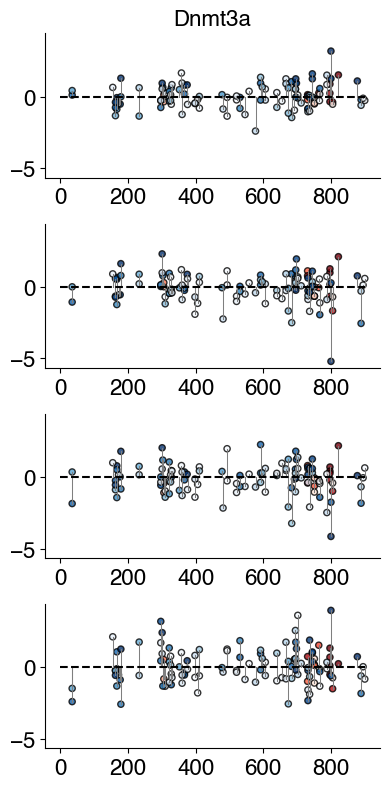

In [16]:

#for idx, gene in enumerate(top_genes[:5]):


gene = 'Dnmt3a'

ptprt = cc1[(cc1['gene_name_m']==gene) & (cc1['legacy']==False) & (cc1['classification_h'].isin(['Missense', 'Nonsense']))]

ptprt['codon'] = [int(i[1:-1]) for i in ptprt['HGVSp_m']]

fig, ax = plt.subplots(4,1,figsize=(4,8), sharey=True)


samples = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']
samp_dict = dict(zip(samples, ['In Vitro', 'Spleen', 'Bone', 'Meninges']))
for kk, val2 in enumerate(samples):

    for i, val in ptprt.iterrows():
        x = val['codon']
        y = val[val2]

        ax[kk].plot([x,x],[0,y], color='tab:gray', linewidth=0.75)


    ptprt1 = ptprt[ptprt['Editor']=='ABE']
    ptprt2 = ptprt[ptprt['Editor']=='CBE']

    print(len(ptprt))
    marker_sizes1 = 5*(-np.log10(np.asarray(sorted(ptprt1[f'FDR_{val2[4:]}']))+1e-10))**2 + 20
    marker_sizes2 = 5*(-np.log10(np.asarray(sorted(ptprt2[f'FDR_{val2[4:]}']))+1e-10))**2 + 20

    sc = ax[kk].scatter(ptprt1['codon'], ptprt1[val2], c=ptprt1['target_base_edit_perc'], cmap='Reds', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.8)
    
    ax[kk].scatter(ptprt2['codon'], ptprt2[val2], c=ptprt2['target_base_edit_perc'], cmap='Blues', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.8)



    #ax[kk].legend(*sc.legend_elements("sizes", num=6))
    #ax[kk].set_title(samp_dict[val2], fontsize=14)


    ax[kk].spines[['top', 'right']].set_visible(False)
    ax[kk].tick_params(axis='both', which='major', labelsize=16,)
    ax[kk].plot([0, max(ptprt['codon'])], [0,0], linestyle='dashed', color='black',)
    ax[0].set_title(f'{gene}', fontsize=16)

fig.tight_layout()

167
167
167
167
144
144
144
144
153
153
153
153
136
136
136
136
91
91
91
91


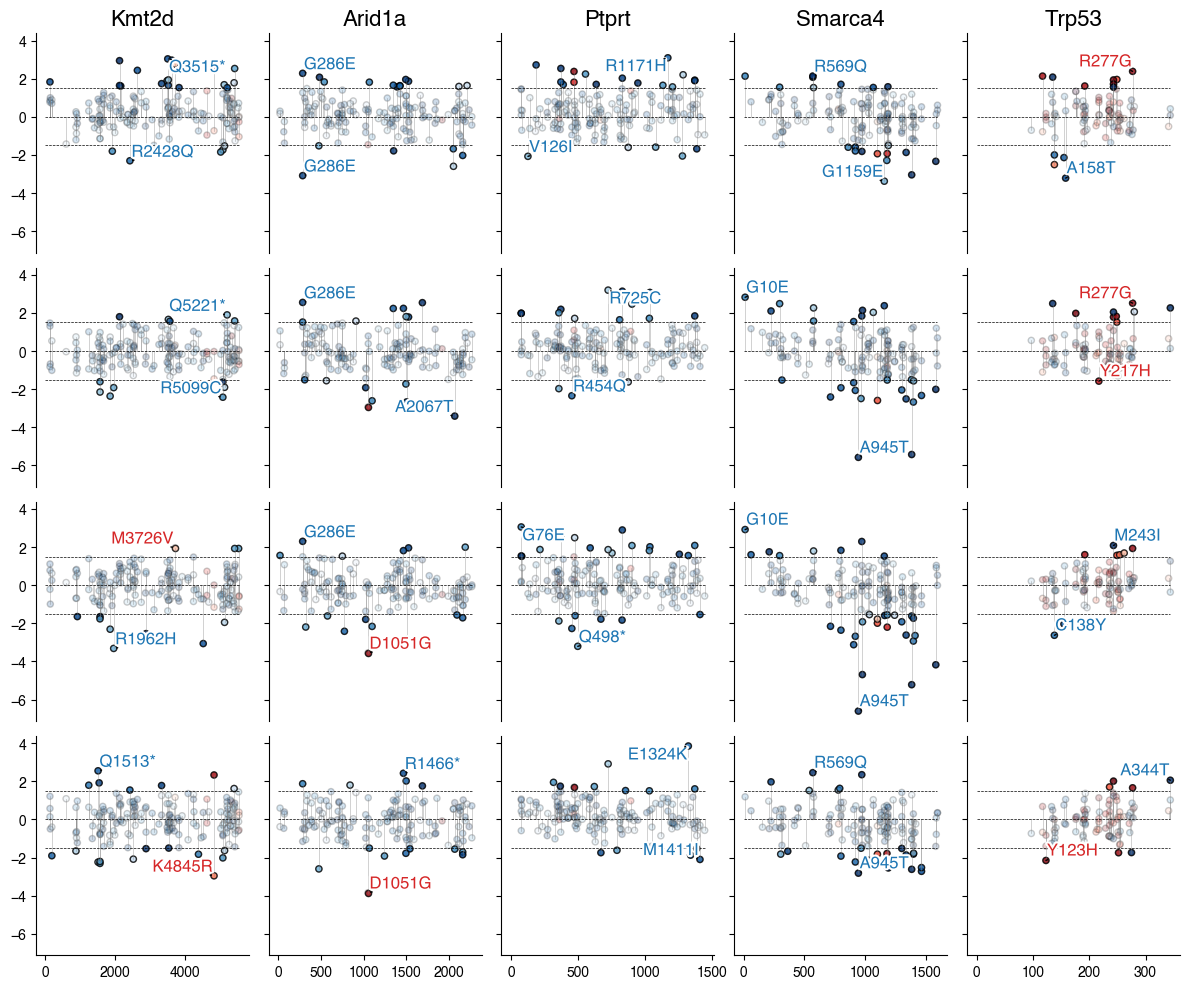

In [17]:

#for idx, gene in enumerate(top_genes[:5]):
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

#gene = 'Smarca4'

genes = ['Kmt2d', 'Arid1a', 'Ptprt', 'Smarca4', 'Trp53']

fig, ax = plt.subplots(4,5,figsize=(12,10), sharey=True) #sharey='col',)


for idx, gene in enumerate(genes):

    ptprt = cc1[(cc1['gene_name_m']==gene) & (cc1['legacy']==False) & (cc1['classification_h'].isin(['Missense', 'Nonsense'])) & (cc1['target_base_edit_perc']>=20)]

    ptprt['codon'] = [int(i[1:-1]) for i in ptprt['HGVSp_m']]


    samples = ['Z_In Vitro D15', 'Z_Spleen', 'Z_Bone', 'Z_Meninges']
    samp_dict = dict(zip(samples, ['In Vitro', 'Spleen', 'Bone', 'Meninges']))
    for kk, val2 in enumerate(samples):

        for i, val in ptprt.iterrows():
            x = val['codon']
            y = val[val2]

            ax[kk][idx].plot([x,x],[0,y], color='tab:gray', linewidth=0.5, alpha=.5)


        ptprt1 = ptprt[ptprt['Editor']=='ABE']
        ptprt2 = ptprt[ptprt['Editor']=='CBE']

        print(len(ptprt))
        #marker_sizes1 = 5*(-np.log10(np.asarray(sorted(ptprt1[f'FDR_{val2[4:]}']))+1e-10))**2 + 20
        #marker_sizes2 = 5*(-np.log10(np.asarray(sorted(ptprt2[f'FDR_{val2[4:]}']))+1e-10))**2 + 20


        ptprt1_1 = ptprt1[(ptprt1[val2]<=1.5) | (ptprt1[val2]>=-1.5)]
        ptprt1_2 = ptprt1[(ptprt1[val2]>=1.5) | (ptprt1[val2]<=-1.5)]
        ptprt2_1 = ptprt2[(ptprt2[val2]<=1.5) | (ptprt2[val2]>=-1.5)]
        ptprt2_2 = ptprt2[(ptprt2[val2]>=1.5) | (ptprt2[val2]<=-1.5)]

        #ptprt1_1 = ptprt1[(ptprt1[val2]<=1.5)] 
        #ptprt1_2 = ptprt1[(ptprt1[val2]>=1.5)] 
        #ptprt2_1 = ptprt2[(ptprt2[val2]<=1.5)] 
        #ptprt2_2 = ptprt2[(ptprt2[val2]>=1.5)]

        ax[kk][idx].scatter(ptprt1_1['codon'], ptprt1_1[val2], c=ptprt1_1['target_base_edit_perc'], cmap='Reds', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.2)
        ax[kk][idx].scatter(ptprt1_2['codon'], ptprt1_2[val2], c=ptprt1_2['target_base_edit_perc'], cmap='Reds', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.8)



        ax[kk][idx].scatter(ptprt2_1['codon'], ptprt2_1[val2], c=ptprt2_1['target_base_edit_perc'], cmap='Blues', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.2)
        ax[kk][idx].scatter(ptprt2_2['codon'], ptprt2_2[val2], c=ptprt2_2['target_base_edit_perc'], cmap='Blues', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.8)

        #and annotate top 2 and bototm 2 variants
           #and annotate top and bottom 5 variant
        tops = pd.concat((ptprt1_2, ptprt2_2)).sort_values(by=val2, ascending=False)[:1]
        bottoms = pd.concat((ptprt1_2, ptprt2_2)).sort_values(by=val2, ascending=True)[:1]
        tb = pd.concat((tops, bottoms))

        t = []
        x = []
        y = []
        c = []

        c_dict2 = {'ABE':'tab:red', 'CBE':'tab:blue'}
        for i, val3 in tb.iterrows():
            y.append(val3[val2])
            x.append(val3['codon'])
            c.append(c_dict2[val3['Editor']])
            a = val3['HGVSp_m']
    
            t.append(a)


        texts = [ax[kk][idx].text(x[i], y[i], t[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                    foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

        adjust_text(texts, only_move={'points':'xy', 'texts':'xy'}, ax=ax[kk][idx], arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))



        #ax[kk].legend(*sc.legend_elements("sizes", num=6))
        #ax[kk].set_title(samp_dict[val2], fontsize=14)

        if kk==3:
            ax[kk][idx].spines[['top', 'right']].set_visible(False)
        else:
            ax[kk][idx].spines[['top', 'right', 'bottom']].set_visible(False)
            ax[kk][idx].set_xticks([])


        ax[kk][idx].tick_params(axis='both', which='major', labelsize=10,)
        ax[kk][idx].plot([0, max(ptprt['codon'])], [0,0], linestyle='dashed', color='black',linewidth=.5)
        ax[kk][idx].plot([0, max(ptprt['codon'])], [1.5,1.5], linestyle='dashed', color='black',linewidth=.5)
        ax[kk][idx].plot([0, max(ptprt['codon'])], [-1.5,-1.5], linestyle='dashed', color='black',linewidth=.5)

        ax[kk][idx].set_yticks([-6,-4,-2,0,2,4])

        ax[0][idx].set_title(f'{gene}', fontsize=16)
        #ax[0][idx].set_ylim(-5,5)
        ax[kk][idx].patch.set_facecolor('None')

fig.tight_layout()
#fig.savefig('figures/lolliplops_15_transparent.png', dpi=300)

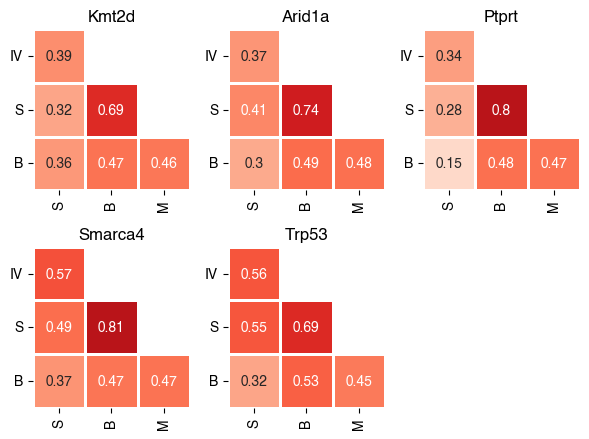

In [18]:
genes = ['Kmt2d', 'Arid1a', 'Ptprt', 'Smarca4', 'Trp53']
samples = ['Z_In Vitro D15', 'Z_Spleen', 'Z_Bone', 'Z_Meninges']

fig, ax = plt.subplots(2,3,figsize=(6,4.5), sharey='col',)





for idx, gene in enumerate(genes):

    ptprt = cc1[(cc1['gene_name_m']==gene) & (cc1['legacy']==False) & (cc1['classification_h'].isin(['Missense', 'Nonsense'])) & (cc1['target_base_edit_perc']>=0)]

    corr_mat = ptprt[samples].corr(method='pearson')
    #mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    mask = np.array([[False,  True,  True],
       [False, False,  True],
       [False, False, False]])
# Plot the heatmap with the mask

    corr_mat = corr_mat[['Z_In Vitro D15', 'Z_Spleen', 'Z_Bone']]
    sns.heatmap(data = corr_mat[1:], ax=ax[idx//3][idx%3], annot=True, mask=mask, linewidths=1, cbar=False, vmin=0, vmax=1, cmap='Reds')
    ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
    ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
    ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)


fig.delaxes(ax[1][2])
fig.tight_layout()
#fig.savefig('figures/corr_heatmaps.pdf')

In [429]:
corr_mat[]

,Z_In Vitro D15,Z_Spleen,Z_Bone,Z_Meninges
Z_In Vitro D15,1.000000,0.389294,0.318648,0.357978
Z_Spleen,0.389294,1.000000,0.685667,0.472146
Z_Bone,0.318648,0.685667,1.000000,0.459569
Z_Meninges,0.357978,0.472146,0.459569,1.000000


In [425]:
mask

array([[ True,  True,  True,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True]])

In [ ]:
np.array([[False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True]])

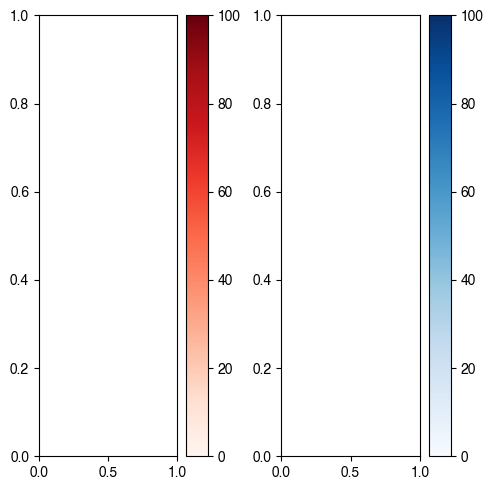

In [277]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
from matplotlib import cm, colors
cmap = cm.get_cmap("seismic")
norm = colors.Normalize(0, 100)

fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax[0])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='Blues'), ax=ax[1])

fig.tight_layout()
#fig.savefig('figures/colorbar.pdf')

In [408]:
2//3

0

# DNMT3a

In [332]:
scanning = pd.read_csv('source_data/dnmt3a_scanning.csv', header=1) #.dropna()


scan = scanning.dropna(subset='Mutation_list')
scan = scan[scan['Mutation_list']!='Not_in_3A1']

mut1 = []
mut2 = []
mut3 = []
for i, val  in scan.iterrows():
    mut = val['Mutation_list']
    if type(mut)==str:
        if ',' in mut:
            j = mut.split(', ')
            #print(j)
            for idx, val2 in enumerate(j):
                if idx==0:
                    mut1.append(val2)
                if idx==1:
                    mut2.append(val2)
                if idx==2:
                    mut3.append(val2)

            if len(j)==2:
                mut3.append(None)

        else:
            mut1.append(mut)
            mut2.append(None)
            mut3.append(None)

    else:
        mut1.append(None)
        mut2.append(None)
        mut3.append(None)

scan['mut1'] = mut1
scan['mut2'] = mut2
scan['mut3']= mut3

In [334]:
scan

,sgRNA_ID,sgRNA_seq,Mut_type,Domain,Mutation_list,sgRNA_score_d9_citrine_positive,Hit_status,Validated,Name_used_in_paper,mut1,mut2,mut3
0,DNMT3A2_486,GCCCCACTCCTGGATCTGGG,Nonsense,MTase,W698*,1.751051,enriched,Yes,sgW698 in paper,W698*,None,None
1,DNMT3A2_456,ACACCTCCGAGGCAATGTAG,Missense,MTase,"E664K, V665M",1.735522,enriched,Yes,sgE664/V665 in paper,E664K,V665M,None
3,DNMT3A2_532,TCTCAAAGAGCCAGAAGAAG,Missense,MTase,E756K,1.635047,enriched,NaN,NaN,E756K,None,None
4,DNMT3A2_339,GCGTACCAGTACGACGACGA,Nonsense,ADD,Q527*,1.601537,enriched,NaN,NaN,Q527*,None,None
5,DNMT3A2_522,ACCGCCTCCTGCATGATGCG,Missense,MTase,L737F,1.598453,enriched,Yes,sgL737 in paper,L737F,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
715,DNMT3A2_312,GGTGTTCCAGGGTAACATTG,Missense,ADD,E505K,-0.388036,unchanged,NaN,NaN,E505K,None,None
717,DNMT3A2_381,CGCACATGTAGCAGTTCCAG,Missense,ADD,M585I,-0.397557,unchanged,NaN,NaN,M585I,None,None
718,DNMT3A2_310,GGTAACATTGAGGCTCCCAC,Missense,ADD,V502I,-0.407768,unchanged,NaN,NaN,V502I,None,None
723,DNMT3A2_343,CCCACAGCAGATGGTGCAGT,Missense,ADD,"C540Y, C541Y",-0.469471,depleted,NaN,NaN,C540Y,C541Y,None


In [349]:

g_list = []

hh = np.unique(master_targ[master_targ['gene_name_h']=='DNMT3A']['HGVSp_h'])

for i, val in scan.iterrows():

    m1 = val['mut1']
    m2 = val['mut2']
    m3 = val['mut3']

    guide = val['sgRNA_ID']

    if m1 in hh:
        g_list.append(guide)

    if m2 in hh:
        g_list.append(guide)

    if m3 in hh:
        g_list.append(guide)

guides = np.unique(g_list)

scan_subset = scan[scan['sgRNA_ID'].isin(guides)]

hgvsp_h = []

for i, val in scan_subset.iterrows():
    m1 = val['mut1']
    m2 = val['mut2']
    m3 = val['mut3']

    guide = val['sgRNA_ID']

    if m1 in hh:
        hgvsp_h.append(m1)

    elif m2 in hh:
        hgvsp_h.append(m2)

    if m3 in hh:
        hgvsp_h.append(m3)

scan_subset['HGVSp_h'] = hgvsp_h

PearsonRResult(statistic=-0.28090598304495673, pvalue=0.3764652998933276)

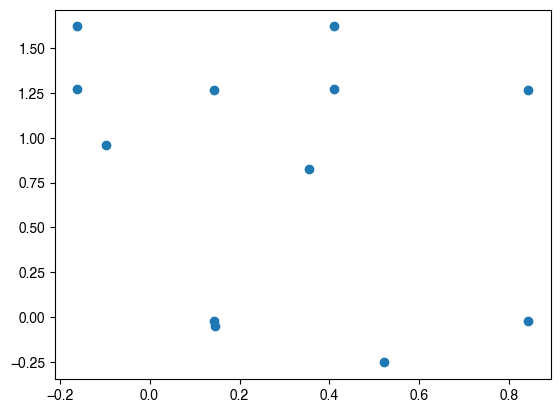

In [377]:
dnmt3a = master_targ[master_targ['gene_name_h']=='DNMT3A']

combined = pd.merge(scan_subset, dnmt3a, on='HGVSp_h')

combined = combined[combined['target_base_edit_perc']>=80]

x = combined['sgRNA_score_d9_citrine_positive']
y = combined['LFC_In Vitro D15']
plt.scatter(x,y)
scipy.stats.pearsonr(x,y)

In [378]:
scan_subset.sort_values(by='sgRNA_score_d9_citrine_positive')

,sgRNA_ID,sgRNA_seq,Mut_type,Domain,Mutation_list,sgRNA_score_d9_citrine_positive,Hit_status,Validated,Name_used_in_paper,mut1,mut2,mut3,HGVSp_h
663,DNMT3A2_399,TAGCGAAGAACATCTGGAGC,Missense,ADD,A610T,-0.183414,unchanged,NaN,NaN,A610T,None,None,A610T
654,DNMT3A2_530,GGGGCGATCATCTCCCTCCT,Missense,MTase,R749H,-0.160478,unchanged,NaN,NaN,R749H,None,None,R749H
598,DNMT3A2_225,CTTCCAGCCTTCTGGCCCTA,Nonsense,Inter1,"Q415*, P416S",-0.098090,unchanged,NaN,NaN,Q415*,P416S,None,Q415*
596,DNMT3A2_489,GATCGAATGGGCCCCACTCC,Missense,MTase,D702N,-0.096085,unchanged,NaN,NaN,D702N,None,None,D702N
555,DNMT3A2_131,GGCCAGGCCGCATTGTGTCT,Missense,PWWP,P307L,-0.059215,unchanged,NaN,NaN,P307L,None,None,P307L
476,DNMT3A2_226,TTCCAGCCTTCTGGCCCTAA,Nonsense,Inter1,"Q415*, P416F",-0.009032,unchanged,NaN,NaN,Q415*,P416F,None,Q415*
465,DNMT3A2_216,CCCAGGGCCCATTCAATCAT,Missense,Inter1,A410T,-0.000862,unchanged,NaN,NaN,A410T,None,None,A410T
450,DNMT3A2_144,ACCCGCTGGGTCATGTGGTT,Missense,PWWP,R326C,0.008723,unchanged,NaN,NaN,R326C,None,None,R326C
437,DNMT3A2_204,CCGCGCGGGGAAGCTGTTCC,Missense,Inter1,A380V,0.015557,unchanged,NaN,NaN,A380V,None,None,A380V
362,DNMT3A2_380,GTTCCAGGGGTCTTCCTTAA,Nonsense,ADD,W581*,0.054314,unchanged,NaN,NaN,W581*,None,None,W581*


In [390]:
dnmt3a[dnmt3a['HGVSp_h'].isin(scan_subset[scan_subset['Hit_status']=='enriched']['HGVSp_h'])][['HGVSp_h', 'target_base_edit_perc', 'corr_perc', 'LFC_Bone', 'LFC_Spleen', 'LFC_Meninges', "LFC_In Vitro D15"]]

,HGVSp_h,target_base_edit_perc,corr_perc,LFC_Bone,LFC_Spleen,LFC_Meninges,LFC_In Vitro D15
2704,W314*,43.244782,10.417457,-1.401700,-1.172500,-1.24460,0.287520
2705,W314*,0.768907,0.136929,-0.964260,-0.683620,-1.32130,0.244540
2736,T671M,12.995492,0.015545,0.474150,-0.237990,-0.79909,1.266700
2737,T671M,30.803571,6.696429,0.583940,0.929890,1.76980,0.930680
2739,W330*,0.000000,0.000000,0.174410,0.708200,0.78312,0.149840
2740,W330*,35.257083,0.000000,-0.332060,-0.232700,0.15927,-0.255250
2741,R301W,89.384010,62.975098,-0.560500,0.041045,3.22990,-0.252250
2742,R301W,7.471764,5.386620,-0.342190,0.125420,1.72820,-0.247910
2743,R301W,73.306506,8.182428,0.023201,0.162500,0.46415,-0.741430
2758,P700L,98.652064,7.385566,-0.069468,-0.220820,-0.18262,1.267300


In [329]:
dnmt3a = master_targ[master_targ['gene_name_h']=='DNMT3A']



for i, val in dnmt3a.iterrows():

    hg = val['HGVSp_h']

    if hg['']

,sgRNA_ID,sgRNA_seq,Gene,sgRNA_pos,sgRNA_strand,Edit_window,Targeted_exon,Win_overlap,C_count,Splice_check,Mut_type,Domain,Mut_list_3A1,Edit_site_3A1,Mut_list_3A2,Edit_site_3A2,mut1,mut2,mut3
46,DNMT3A2_047,TTGGCTTTCTTCTCAGCCTG,DNMT3A,25248236,antisense,"(25248239, 25248243)",2,Exon,1,NaN,Missense,Nterm,A218T,218.0,A29T,29.0,A218T,None,None
47,DNMT3A2_048,CTTGGCTTTCTTCTCAGCCT,DNMT3A,25248235,antisense,"(25248238, 25248242)",2,Exon,1,NaN,Missense,Nterm,A218T,218.0,A29T,29.0,A218T,None,None
48,DNMT3A2_049,CCTTGGCTTTCTTCTCAGCC,DNMT3A,25248234,antisense,"(25248237, 25248241)",2,Exon,1,NaN,Missense,Nterm,A218T,218.0,A29T,29.0,A218T,None,None
49,DNMT3A2_050,CCAGGCTGAGAAGAAAGCCA,DNMT3A,25248256,sense,"(25248249, 25248253)",2,Exon/Intron,1,NaN,Missense,Nterm,A214V,214.0,A25V,25.0,A214V,None,None
50,DNMT3A2_051,AAGAAAGCCAAGGTCATTGC,DNMT3A,25248246,sense,"(25248239, 25248243)",2,Exon,1,NaN,Missense,Nterm,A218V,218.0,A29V,29.0,A218V,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,DNMT3A2_646,TGACTGGCACGCTCCATGAC,DNMT3A,25234326,antisense,"(25234329, 25234333)",18,Exon,2,NaN,Missense,MTase,V897I,897.0,V708I,708.0,V897I,None,None
649,DNMT3A2_650,CCACCTCTTCGCTCCGCTGA,DNMT3A,25234321,sense,"(25234314, 25234318)",18,Exon,3,NaN,Missense,MTase,L901F,901.0,L712F,712.0,L901F,None,None
650,DNMT3A2_651,ACTCCTTCAGCGGAGCGAAG,DNMT3A,25234296,antisense,"(25234299, 25234303)",18,Exon,3,NaN,Missense,MTase,E907K,907.0,E718K,718.0,E907K,None,None
651,DNMT3A2_652,CACGCAAAATACTCCTTCAG,DNMT3A,25234286,antisense,"(25234289, 25234293)",18,Exon,1,NaN,Missense,MTase,A910T,910.0,A721T,721.0,A910T,None,None


In [346]:
dnmt3a = master_targ[master_targ['gene_name_h']=='DNMT3A']


71

In [330]:
scan = scanning.dropna(subset='Mutation_list')
scan = scan[scan['Mutation_list']!='Not_in_3A1']



,sgRNA_ID,sgRNA_seq,Mut_type,Domain,Mutation_list,sgRNA_score_d9_citrine_positive,Hit_status,Validated,Name_used_in_paper
0,DNMT3A2_486,GCCCCACTCCTGGATCTGGG,Nonsense,MTase,W698*,1.751051,enriched,Yes,sgW698 in paper
1,DNMT3A2_456,ACACCTCCGAGGCAATGTAG,Missense,MTase,"E664K, V665M",1.735522,enriched,Yes,sgE664/V665 in paper
3,DNMT3A2_532,TCTCAAAGAGCCAGAAGAAG,Missense,MTase,E756K,1.635047,enriched,NaN,NaN
4,DNMT3A2_339,GCGTACCAGTACGACGACGA,Nonsense,ADD,Q527*,1.601537,enriched,NaN,NaN
5,DNMT3A2_522,ACCGCCTCCTGCATGATGCG,Missense,MTase,L737F,1.598453,enriched,Yes,sgL737 in paper
...,...,...,...,...,...,...,...,...,...
715,DNMT3A2_312,GGTGTTCCAGGGTAACATTG,Missense,ADD,E505K,-0.388036,unchanged,NaN,NaN
717,DNMT3A2_381,CGCACATGTAGCAGTTCCAG,Missense,ADD,M585I,-0.397557,unchanged,NaN,NaN
718,DNMT3A2_310,GGTAACATTGAGGCTCCCAC,Missense,ADD,V502I,-0.407768,unchanged,NaN,NaN
723,DNMT3A2_343,CCCACAGCAGATGGTGCAGT,Missense,ADD,"C540Y, C541Y",-0.469471,depleted,NaN,NaN


In [297]:
master_targ[master_targ['gene_name_h']=='DNMT3A']['HGVSp_h']

2662    Q696*
2663    R688H
2664    D768G
2665    G699D
2666    G699D
        ...  
2791    A741V
2792    V716I
2793    R749H
2794    R749H
2795    K826R
Name: HGVSp_h, Length: 134, dtype: object

(array([2449.,  459.,  335.,  277.,  246.,  258.,  219.,  209.,  202.,
         192.,  190.,  173.,  184.,  184.,  160.,  164.,  165.,  186.,
         170.,  168.,  159.,  181.,  148.,  151.,  160.,  171.,  155.,
         183.,  136.,  192.,  181.,  163.,  174.,  172.,  186.,  199.,
         184.,  203.,  196.,  188.,  214.,  217.,  215.,  237.,  226.,
         264.,  292.,  303.,  300.,  424.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <BarContainer object of 50 artists>)

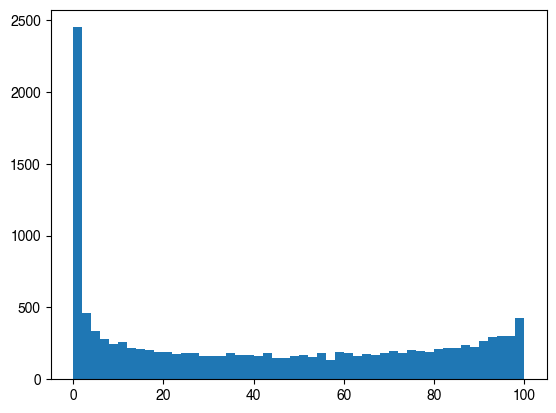

In [396]:
cbe = master_targ[master_targ['Editor']=='CBE']
plt.hist(cbe['target_base_edit_perc'], bins=np.linspace(0,100,51))

# Correlation plots with points labelled

In [475]:
master_targ

,gRNA_id,mutation_idx,gene_name_h,gene_id_h,tx_id_h,chr_h,exon_num_h,strand_h,match,start_h,...,sensor_reads,corr_perc,target_base_edit_perc,byproduct_INDEL_perc,byproduct_sub_perc,Role in Cancer,d_In Vitro D15,d_Spleen,d_Bone,d_Meninges
0,gRNA_1,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133730186.0,...,1192,1.510067,1.929530,1.761745,28.859060,Oncogene,0.514167,-0.248353,-0.023740,-0.242073
1,gRNA_3,0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133730186.0,...,459,0.217865,0.217865,0.000000,19.825708,Oncogene,0.540850,-0.649710,-0.034083,0.142943
2,gRNA_4,3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133760819.0,...,1544,13.341969,28.691710,10.492228,32.448187,Oncogene,-1.365693,-0.288787,0.860787,0.793693
3,gRNA_5,3,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133760819.0,...,1915,46.997389,73.159269,0.156658,35.718016,Oncogene,-0.190560,0.530853,-0.102613,-0.237680
4,gRNA_6,4,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,11.0,+,True,133759553.0,...,5146,18.383210,87.174504,1.943257,76.311698,Oncogene,-0.419683,0.316103,0.322677,-0.219097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14241,gRNA_14408,MBESv1_legacy_577,WT1,NaN,NaN,11,NaN,-,NaN,32421568.0,...,0,0.000000,0.000000,0.000000,0.000000,Oncogene/TSG,0.942792,-1.721275,-0.496875,1.275358
14242,gRNA_14409,MBESv1_legacy_578,WT1,NaN,NaN,11,NaN,-,NaN,32421519.0,...,0,0.000000,0.000000,0.000000,0.000000,Oncogene/TSG,-0.356513,-0.022887,0.330233,0.049167
14243,gRNA_14410,MBESv1_legacy_579,WT1,NaN,NaN,11,NaN,-,NaN,32421519.0,...,0,0.000000,0.000000,0.000000,0.000000,Oncogene/TSG,0.920230,-0.882543,-0.368717,0.331030
14244,gRNA_14411,MBESv1_legacy_580,WT1,NaN,NaN,11,NaN,-,NaN,32421519.0,...,0,0.000000,0.000000,0.000000,0.000000,Oncogene/TSG,0.101619,0.351672,-0.308902,-0.144389


In [52]:
g_list = [['gRNA_9136',
  'gRNA_12301',
  'gRNA_11691',
  'gRNA_8582',
  'gRNA_1840',
  'gRNA_12765',
  'gRNA_13106',
  'gRNA_8374',
  'gRNA_7939',
  'gRNA_8196'],
 ['gRNA_13064',
  'gRNA_3372',
  'gRNA_9609',
  'gRNA_2000',
  'gRNA_3434',
  'gRNA_3520',
  'gRNA_7046',
  'gRNA_11459',
  'gRNA_13096',
  'gRNA_2280'],
 ['gRNA_1279',
  'gRNA_5933',
  'gRNA_3117',
  'gRNA_11197',
  'gRNA_3727',
  'gRNA_1067',
  'gRNA_8419',
  'gRNA_7163',
  'gRNA_6018',
  'gRNA_3825'],
 ['gRNA_2474',
  'gRNA_1719',
  'gRNA_2218',
  'gRNA_7652',
  'gRNA_7038',
  'gRNA_4034',
  'gRNA_11138',
  'gRNA_1140',
  'gRNA_7796',
  'gRNA_7708']]

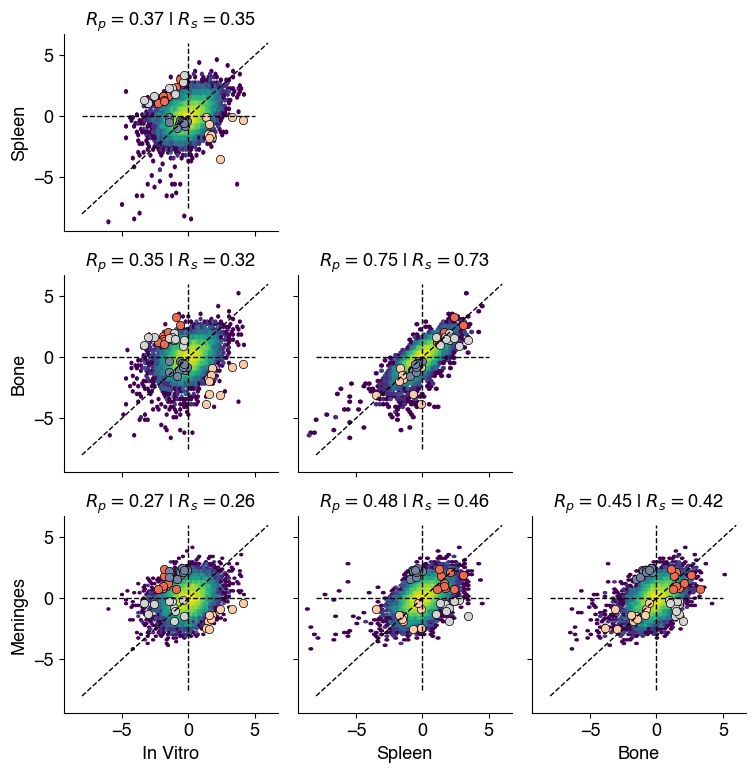

In [53]:
samples = ['Z_In Vitro D15', 'Z_Spleen', 'Z_Bone', 'Z_Meninges']

fig, ax = plt.subplots(4,4,figsize=(10,10), sharex=True, sharey=True)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']


s_dict = {'Z_In Vitro D15': 'In Vitro', 'Z_Spleen': 'Spleen', 'Z_Bone': 'Bone', 'Z_Meninges': 'Meninges'}
for idx, samp in enumerate(samples):

    row = idx
    for idx2, samp2 in enumerate(samples):
        col = idx2
        ax[row][col].hexbin(master_targ[samp2], master_targ[samp], bins='log', gridsize=50)

        ax[row][col].plot([0,0],[-7.5,6], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,5],[0,0], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,6],[-8,6], linestyle='dashed', color='black', linewidth=1)

        ax[row][0].set_ylabel(s_dict[samp], fontsize=13)
        ax[3][col].set_xlabel(s_dict[samp2], fontsize=13)
    #ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
    #ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
    #ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)

        ax[row][col].spines[['top', 'right']].set_visible(False)

        ax[row][col].tick_params(axis='both', which='major', labelsize=13,)

        spear = np.round(scipy.stats.spearmanr(master_targ[samp2], master_targ[samp]).statistic, 2)
        pear = np.round(scipy.stats.pearsonr(master_targ[samp2], master_targ[samp]).statistic, 2)

        ax[row][col].set_title('$R_{p} = $' + f'{pear}' + ' | $R_{s} = $' + f'{spear}', fontsize=13)
        #and also add scatter plot points
        for idx3, k in enumerate(g_list):
            #gene_of_interest = embedded[lfc_table[lfc_table['gRNA_id'].isin(k)].index]

            gene_of_interest = master_targ[master_targ['gRNA_id'].isin(k)]

            ax[row][col].scatter(list(gene_of_interest[samp2]), list(gene_of_interest[samp]),  alpha=1, color=palette[idx3], edgecolor='black', linewidth=.5)


fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][2])
fig.delaxes(ax[0][3])
fig.delaxes(ax[1][1])
fig.delaxes(ax[1][2])
fig.delaxes(ax[1][3])
fig.delaxes(ax[2][2])
fig.delaxes(ax[2][3])
fig.delaxes(ax[3][3])

fig.tight_layout()

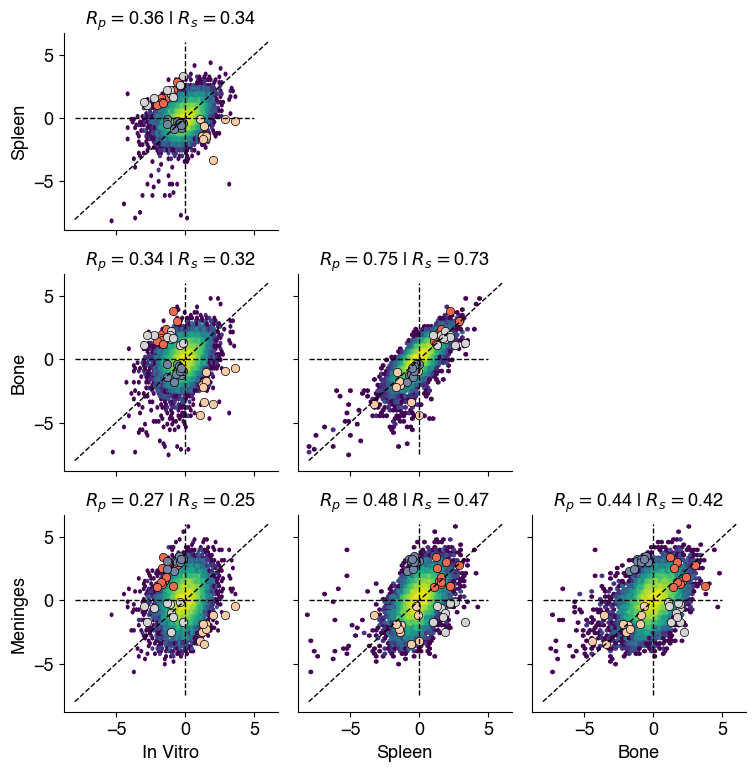

In [54]:
samples = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']

fig, ax = plt.subplots(4,4,figsize=(10,10), sharex=True, sharey=True)

palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']


s_dict = {'LFC_In Vitro D15': 'In Vitro', 'LFC_Spleen': 'Spleen', 'LFC_Bone': 'Bone', 'LFC_Meninges': 'Meninges'}
for idx, samp in enumerate(samples):

    row = idx
    for idx2, samp2 in enumerate(samples):
        col = idx2
        ax[row][col].hexbin(master_targ[samp2], master_targ[samp], bins='log', gridsize=50)

        ax[row][col].plot([0,0],[-7.5,6], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,5],[0,0], linestyle='dashed', color='black', linewidth=1)
        ax[row][col].plot([-8,6],[-8,6], linestyle='dashed', color='black', linewidth=1)

        ax[row][0].set_ylabel(s_dict[samp], fontsize=13)
        ax[3][col].set_xlabel(s_dict[samp2], fontsize=13)
    #ax[idx//3][idx%3].set_xticklabels(['S', 'B', 'M'])
    #ax[idx//3][idx%3].set_yticklabels(['IV', 'S', 'B',])
    #ax[idx//3][idx%3].set_title(f'{gene}', fontsize=12)

        ax[row][col].spines[['top', 'right']].set_visible(False)

        ax[row][col].tick_params(axis='both', which='major', labelsize=13,)

        spear = np.round(scipy.stats.spearmanr(master_targ[samp2], master_targ[samp]).statistic, 2)
        pear = np.round(scipy.stats.pearsonr(master_targ[samp2], master_targ[samp]).statistic, 2)

        ax[row][col].set_title('$R_{p} = $' + f'{pear}' + ' | $R_{s} = $' + f'{spear}', fontsize=13)
        #and also add scatter plot points
        for idx3, k in enumerate(g_list):
            #gene_of_interest = embedded[lfc_table[lfc_table['gRNA_id'].isin(k)].index]

            gene_of_interest = master_targ[master_targ['gRNA_id'].isin(k)]

            ax[row][col].scatter(list(gene_of_interest[samp2]), list(gene_of_interest[samp]),  alpha=1, color=palette[idx3], edgecolor='black', linewidth=.5)


fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][2])
fig.delaxes(ax[0][3])
fig.delaxes(ax[1][1])
fig.delaxes(ax[1][2])
fig.delaxes(ax[1][3])
fig.delaxes(ax[2][2])
fig.delaxes(ax[2][3])
fig.delaxes(ax[3][3])

fig.tight_layout()